In [1]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Sin(nn.Module):
  """
  Hamiltonian neural networks for solving differential equations https://arxiv.org/pdf/2001.11107
  The use of sin(·) instead of more common activation functions, such as Sigmoid(·) and tanh(·), 
  significantly accelerates the network's convergence to a solution
  """
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.sin(x)

In [4]:
def compute_gradient(f, x):
    """
    One-dimensional stationary Schrödinger's equation has the second order derivative
    So we have to compute d/dx (d/dx f)
    This has to be done explicitly and will not be covered by the loss.backward() which will 
    actually compute the gradient of the loss with regards to the model parameters theta
    """
    grad_outputs = torch.ones_like(f, device=x.device)
    gradient = torch.autograd.grad(outputs=f, inputs=x, grad_outputs=grad_outputs, create_graph=True)[0]
    return gradient

In [5]:
def perturb_grid_points(grid, xL, xR, perturbation_factor):
    """
    For the training, a batch of xi points in the interval [xL, xR] is selected as input. In every training iteration (epoch) the
    input points are perturbed by a Gaussian noise to prevent the network from learning the solutions only at fixed points.
    """
    delta = grid[1] - grid[0]

    noise = delta * torch.randn_like(grid) * perturbation_factor
    perturbed_grid = grid + noise

    perturbed_grid[perturbed_grid < xL] = 2*xL - perturbed_grid[perturbed_grid < xL]
    perturbed_grid[perturbed_grid > xR] = 2*xR - perturbed_grid[perturbed_grid > xR]

    perturbed_grid[0] = xL
    perturbed_grid[-1] = xR

    perturbed_grid.requires_grad = False

    return perturbed_grid

In [6]:
def parametric_function(x, xL, xR):
    """
    Selecting an appropriate parametric function g(x) is necessary for enforcing boundary conditions. 
    The following parametric equation enforces a f (xL) = f (xR) = 0 boundary conditions
    """
    # IT SEEMS EITHER THE PAPER IS WRONG OR THEIR IMPLEMENTATION
    # (1 - torch.exp(-(x - xL))) * (1 - torch.exp(-(x - xR))) would be expected
    # but their implementation has
    # ...-(x - xL)  * ... (x - xR)

    return (1 - torch.exp(-(x - xL))) * (1 - torch.exp(x - xR))


def parametric_trick(x, xL, xR, boundary_value, neural_net):
    """
    The predicted eigenfunctions are defined using a parametric trick, i.e are not directly computed by the neural network
    The neural network returns a tuple: network_prediction and learnable_lambda
    """
    network_prediction, _ = neural_net(x)
    g = parametric_function(x, xL, xR)
    return boundary_value + g * network_prediction


In [7]:
def compute_schroedinger_loss_residual_and_hamiltonian(x, psi, E, V):
    """
    Schrödingers loss is the mean of the residual. Hamiltonian is used for verification. 
    The main reason to couple the computations is to use only one autograd pass
    """
    psi_dx = compute_gradient(psi, x)
    psi_ddx = compute_gradient(psi_dx, x)

    residual = 0.5 * psi_ddx + (E - V) * psi
    schroeddinger_loss = (residual.pow(2)).mean()
    hamiltonian = -0.5 * psi_ddx + V * psi

    return schroeddinger_loss, residual, hamiltonian


In [8]:
class Quantum_NN(nn.Module):
    """
    Network for the 1D PINN task
    """
    def __init__(self, hidden_dim=10, symmetry=True):
        super().__init__()
        self.symmetry = symmetry

        self.activation = Sin()
        self.input = nn.Linear(1, 1)
        self.first_hidden = nn.Linear(2, hidden_dim)
        self.second_hidden = nn.Linear(hidden_dim + 1, hidden_dim)
        self.output = nn.Linear(hidden_dim + 1, 1)

    def forward(self, t):
        learnable_lambda = self.input(torch.ones_like(t))

        first_hidden_symmetric = self.activation(self.first_hidden(torch.cat((t, learnable_lambda), dim=1)))
        first_hidden_antisymmetric = self.activation(self.first_hidden(torch.cat((-t, learnable_lambda), dim=1)))

        second_hidden_symmetric = self.activation(self.second_hidden(torch.cat((first_hidden_symmetric, learnable_lambda), dim=1)))
        second_hidden_antisymmetric = self.activation(self.second_hidden(torch.cat((first_hidden_antisymmetric, learnable_lambda), dim=1)))

        if self.symmetry:
            network_prediction = self.output(torch.cat((second_hidden_symmetric + second_hidden_antisymmetric, learnable_lambda), dim=1))
        else:
            network_prediction = self.output(torch.cat((second_hidden_symmetric - second_hidden_antisymmetric, learnable_lambda), dim=1))

        return network_prediction, learnable_lambda

In [9]:
def compute_potential(x):
    """
    Compute the finite well potential using heaviside step functions.
    Handles CUDA tensors by converting to CPU for numpy operations.
    
    Parameters:
        x: tensor of position values (can be on CUDA or CPU)
    
    Returns:
        V: potential tensor (on the same device as input x)
    """
    # Store original device
    original_device = x.device
    
    # Move to CPU and convert to numpy
    x_numpy = x.cpu().detach().numpy()
    
    # Compute potential using numpy heaviside
    V_numpy = (np.heaviside(-1*x_numpy - 1.7, 0) + np.heaviside(x_numpy - 1.7, 0)) * 20
    
    # Convert back to torch tensor and move to original device
    V = torch.from_numpy(V_numpy).float().to(original_device)
    
    return V

Text(0, 0.5, 'V')

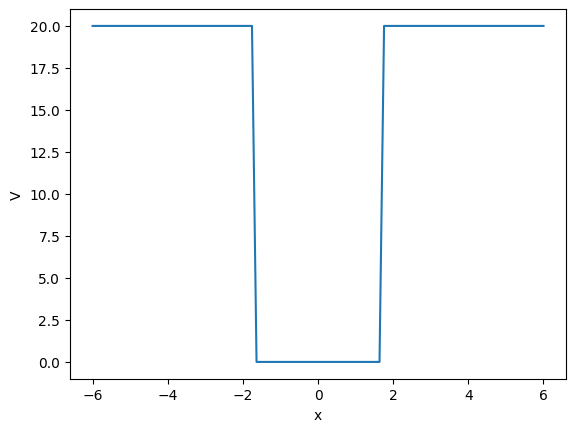

In [10]:
plotxs = np.linspace(-6,6,100)
L = 1
plotys = compute_potential(torch.tensor(plotxs))
plt.plot(plotxs, plotys)
plt.xlabel('x')
plt.ylabel('V')

In [11]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear) and layer.weight.shape[0] != 1:
        nn.init.xavier_uniform_(layer.weight.data)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias.data)

In [12]:
def train_nn(xL, xR, boundary_condition, hidden_dim, epochs, num_grid_points, lr, minibatch_number=1):
    """
    Train a neural network to solve the finite well quantum problem.
    
    Args:
        xL, xR: Domain boundaries
        boundary_condition: Represents f_b in the paer
        hidden_dim: Dimension of the hidden layers
        epochs: Number of training iterations
        n_train: Number of training points
        lr: Learning rate
        minibatch_number: Number of minibatches per epoch
    """
    
    # ============ INITIALIZATION ============
    # Initialize network and move to GPU
    nn_model = Quantum_NN(hidden_dim).to(device)
    
    # Setup optimizer with standard Adam hyperparameters for stability
    betas = (0.999, 0.9999)
    optimizer = optim.Adam(nn_model.parameters(), lr=lr, betas=betas)
    
    # ============ LOSS TRACKING DICTIONARIES ============
    # Track different loss components throughout training
    loss_histories = {
        'total': [],
        'SE': [],           # Schrödinger equation loss
        'normalization': [], # Wavefunction normalization loss
        'orthogonality': [], # Orthogonality constraint loss
        'energy': [],       # Energy eigenvalue losses
    }
    
    energy_history = []     # Track computed energy eigenvalues
    eigenstate_dict = {}    # Store best models for each energy level
    
    # ============ ORTHOGONALITY STATE TRACKING ============
    # These variables track the progressive orthogonalization procedure
    orth_counter = 0        # Counts how many eigenstates have been found
    convergence_threshold = np.exp(-14)  # Threshold for reweighting
    
    # Initialize eigenstate storage: {energy_level: (model, loss, data)}
    for i in range(50):
        eigenstate_dict[i] = (None, 1e+20)
    
    best_model = None
    best_loss = 1e+20
    
    # ============ GRID AND DATA SETUP ============
    # Create initial training grid and reshape for network input
    grid = torch.linspace(xL, xR, num_grid_points).reshape(-1, 1)
    batch_size = num_grid_points // minibatch_number
    
    # ============ TRAINING LOOP ============
    start_time = time.time()
    internal_se_loss = []  # Track SE loss for convergence detection
    
    for epoch in range(epochs):
        # Perturb evaluation points slightly (improves generalization)
        # Keep first point fixed at t0 (boundary condition)
        perturbed_grid = perturb_grid_points(grid, xL, xR, perturbation_factor=0.03*xR)
        shuffled_grid = perturbed_grid[torch.randperm(num_grid_points)]
        shuffled_grid.requires_grad = True
        
        batch_start, batch_end = 0, batch_size
        epoch_loss = 0.0
        
        # ============ MINIBATCH LOOP ============
        for batch_idx in range(minibatch_number):
            # Extract current minibatch
            points_batch = shuffled_grid[batch_start:batch_end].to(device)
            
            # ============ FORWARD PASS ============
            # Get network predictions: wavefunction (nn) and energy (En)
            nn_output, energy = nn_model(points_batch)
            energy = torch.abs(energy)  # Ensure positive energy
            energy_history.append(energy[0].item())
            
            # Compute parametric solution (enforces boundary conditions)
            
            psi = parametric_trick(points_batch, xL, xR, boundary_condition, nn_model).to(device)
            potential = compute_potential(points_batch)
            
            # Main physics loss: Schrödinger equation residual
            se_loss, residual, hamiltonian_psi = compute_schroedinger_loss_residual_and_hamiltonian(points_batch, psi, energy, potential)
            internal_se_loss.append(se_loss.cpu().detach().numpy())
            
            total_loss = se_loss
            
            # ============ NORMALIZATION CONSTRAINT ============
            # Add penalty if wavefunction isn't properly normalized
            norm_squared = torch.dot(psi[:, 0], psi[:, 0])
            target_norm_squared = (num_grid_points / (xR - xL)) * 1.0
            normalization_loss = (target_norm_squared - torch.sqrt(norm_squared)) ** 2
            total_loss += normalization_loss
            
            # ============ CONVERGENCE MONITORING ============
            # Compute rolling average of SE loss gradient to detect plateaus
            window_size = 1000
            if len(internal_se_loss) >= window_size + 1:
                loss_slope = np.mean(
                    np.array(internal_se_loss[-window_size:]) - 
                    np.array(internal_se_loss[-window_size-1:-1])
                )
            elif len(internal_se_loss) > 1:
                loss_slope = np.mean(
                    np.array(internal_se_loss[1:]) - 
                    np.array(internal_se_loss[:-1])
                )
            else:
                loss_slope = 0.0
            
            # Print progress every 300 epochs
            if epoch % 300 == 0:
                print(f'Epoch {epoch} | Energy {energy_history[-1]:.6f} | '
                      f'Loss slope {loss_slope:.2e} | Orth count {orth_counter}')
            
            # ============ ORTHOGONALIZATION PROCEDURE ============
            # Progressively enforce orthogonality to previously found eigenstates
            # This enables the network to find multiple eigenvalues
            
            trigger_reweight = (
                loss_slope < convergence_threshold and 
                loss_slope > 0 and
                epoch > 1000  # Avoid early reweighting
            )
            
            # Fixed reweighting at epoch 15000
            if epoch == 15000:
                nn_model.apply(initialize_weights)
                orth_counter += 1
                print(f'Epoch {epoch} [FIXED REWEIGHT] | Orth count {orth_counter}')
            
            # Adaptive reweighting when convergence detected
            elif trigger_reweight:
                if orth_counter < 3:
                    nn_model.apply(initialize_weights)
                    orth_counter += 1
                    print(f'Epoch {epoch} [ADAPTIVE REWEIGHT] | Orth count {orth_counter}')
                elif orth_counter == 3:
                    nn_model.sym = False  # Break symmetry for next eigenstate
                    orth_counter += 1
                    print(f'Epoch {epoch} [SYMMETRY BREAK] | Orth count {orth_counter}')
                else:
                    orth_counter += 1
                    print(f'Epoch {epoch} [CONTINUE] | Orth count {orth_counter}')
            
            # ============ ORTHOGONALITY LOSS ============
            # Penalize overlap with previously found eigenstates
            ortho_loss = torch.tensor(0.0)
            
            if orth_counter == 1 and eigenstate_dict[0][0] is not None:
                # Orthogonal to first eigenstate
                psi_prev = parametric_trick(points_batch, xL, xR, boundary_condition, eigenstate_dict[0][0])
                overlap = torch.dot(psi_prev[:, 0], psi[:, 0]) ** 2
                ortho_loss = torch.sqrt(overlap) / 25
                
            elif orth_counter >= 2 and eigenstate_dict[0][0] is not None:
                # Orthogonal to multiple previous eigenstates
                psi_states = [parametric_trick(points_batch, xL, xR, boundary_condition, eigenstate_dict[i][0])
                    for i in range(min(orth_counter, 4))
                    if eigenstate_dict[i][0] is not None
                ]
                combined_overlap = torch.dot(
                    torch.sum(torch.cat(psi_states, dim=1), dim=1),
                    psi[:, 0]
                ) ** 2
                ortho_loss = torch.sqrt(combined_overlap) / 25
            
            total_loss += ortho_loss
            
            # ============ BACKWARD PASS AND OPTIMIZATION ============
            total_loss.backward(retain_graph=False)
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += total_loss.cpu().detach().item()
            
            # ============ BOOKKEEPING ============
            # Track losses and update best model
            loss_histories['total'].append(total_loss.item())
            loss_histories['SE'].append(se_loss.item())
            loss_histories['normalization'].append(normalization_loss.item())
            loss_histories['orthogonality'].append(ortho_loss.item() if ortho_loss != 0 else 0)
            loss_histories['energy'].append(energy_history)
            
            batch_start += batch_size
            batch_end += batch_size
        
        # ============ POST-EPOCH UPDATES ============
        # Keep best model overall (lowest SE loss)
        if se_loss < best_loss:
            best_model = copy.deepcopy(nn_model)
            best_loss = se_loss
        
        # Store best model for each energy level bin
        energy_bin = int(abs(energy[0].item()) // 1)
        if energy_bin < 50 and se_loss < eigenstate_dict[energy_bin][1]:
            eigenstate_dict[energy_bin] = (copy.deepcopy(nn_model), se_loss, (points_batch, residual, hamiltonian_psi, psi))
    
    # ============ CLEANUP AND RETURN ============
    end_time = time.time()
    runtime = end_time - start_time
    
    return best_model, loss_histories, runtime, nn_model #, eigenstate_dict

In [ ]:
xL = -6.
xR = 6.
boundary_condition = 0.
num_grid_points = 1200
hidden_dim = 100
epochs = int(7e4)
lr = 1e-2
minibatch_number = 1

best_model, loss_histories, runtime, last_model = train_nn(xL, xR, boundary_condition, hidden_dim, epochs, num_grid_points, lr, minibatch_number)

Epoch 0 | Energy 0.495739 | Loss slope 0.00e+00 | Orth count 0
Epoch 300 | Energy 0.072082 | Loss slope 9.38e-02 | Orth count 0
Epoch 600 | Energy 0.021907 | Loss slope 4.58e-02 | Orth count 0
Epoch 900 | Energy 0.050108 | Loss slope 8.81e-03 | Orth count 0
Epoch 1200 | Energy 0.004252 | Loss slope -6.08e-02 | Orth count 0
Epoch 1500 | Energy 0.012434 | Loss slope -2.16e-02 | Orth count 0
Epoch 1800 | Energy 0.000977 | Loss slope -8.98e-03 | Orth count 0
Epoch 2100 | Energy 0.020957 | Loss slope -9.29e-03 | Orth count 0
Epoch 2400 | Energy 0.057232 | Loss slope -3.11e-03 | Orth count 0
Epoch 2700 | Energy 0.111523 | Loss slope -3.23e-03 | Orth count 0
Epoch 3000 | Energy 0.158266 | Loss slope -2.06e-03 | Orth count 0
Epoch 3300 | Energy 0.203027 | Loss slope -1.19e-03 | Orth count 0
Epoch 3600 | Energy 0.243386 | Loss slope -1.44e-03 | Orth count 0
Epoch 3900 | Energy 0.276225 | Loss slope -1.14e-03 | Orth count 0
Epoch 4200 | Energy 0.310334 | Loss slope -6.75e-04 | Orth count 0
Epoch

In [ ]:
print('Training time (minutes):', runtime/60)
plt.figure(figsize = (8,6))
plt.loglog(loss_histories.get('total'),'-b',alpha=0.975);
plt.ylabel('Total Loss');
plt.xlabel('Epochs');
plt.tight_layout()


In [ ]:
loss_histories.keys()